In [1]:
import sys, os, warnings
from argparse import Namespace
warnings.filterwarnings("ignore")

import torch as ch
from torchvision import transforms
import numpy as np
from PIL import Image
from tqdm import tqdm

from helpers import classifier_helpers
import helpers.data_helpers as dh
import helpers.context_helpers as coh
import helpers.rewrite_helpers as rh
import helpers.vis_helpers as vh

%matplotlib inline

In [2]:
DATASET_NAME = 'ImageNet'
LAYERNUM = 12
REWRITE_MODE = 'editing'
ARCH = 'vgg16'

## Load model

In [3]:
ret = classifier_helpers.get_default_paths(DATASET_NAME, arch=ARCH)
DATASET_PATH, MODEL_PATH, MODEL_CLASS, ARCH, CD = ret
ret = classifier_helpers.load_classifier(MODEL_PATH, MODEL_CLASS, ARCH,
                            DATASET_NAME, LAYERNUM) 
model, context_model, target_model = ret[:3]

## Load base dataset and vehicles-on-snow data

In [4]:
base_dataset, train_loader, val_loader = dh.get_dataset(DATASET_NAME, DATASET_PATH,
                                                        batch_size=32, workers=8)

==> Preparing dataset imagenet..


In [5]:
train_data, test_data = dh.get_vehicles_on_snow_data(DATASET_NAME, CD)

Test data stats...
ImageNet class: racer, race car, racing car; # Images: 20 

ImageNet class: traffic light, traffic signal, stoplight; # Images: 9 

ImageNet class: tank, army tank, armored combat vehicle, armoured combat vehicle; # Images: 17 

ImageNet class: motor scooter, scooter; # Images: 21 

ImageNet class: car wheel; # Images: 20 

ImageNet class: school bus; # Images: 22 

ImageNet class: fire engine, fire truck; # Images: 20 



Train exemplars


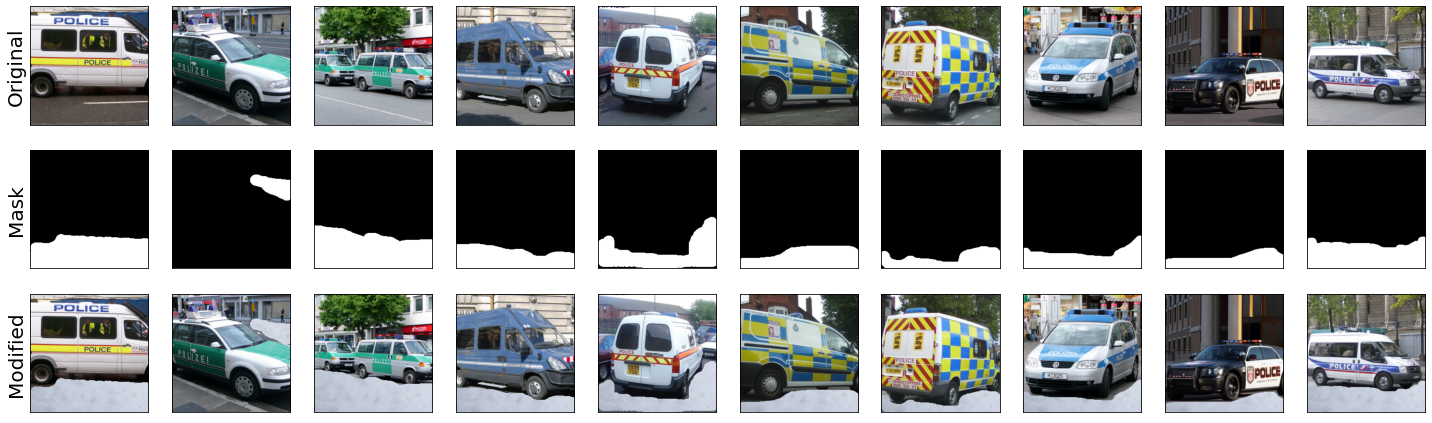

In [6]:
print("Train exemplars")
vh.show_image_row([train_data['imgs'], train_data['masks'], train_data['modified_imgs']], 
                  ['Original', 'Mask', 'Modified'], fontsize=20)

Flickr-sourced test set


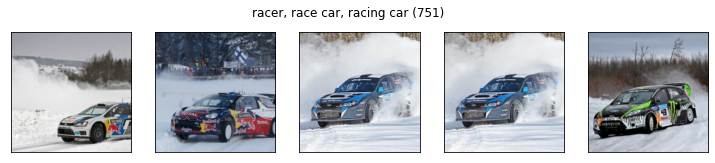

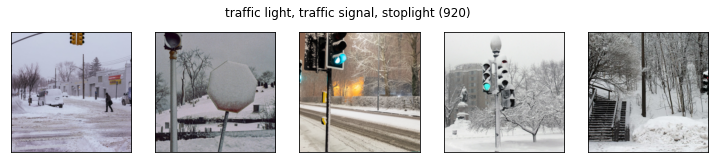

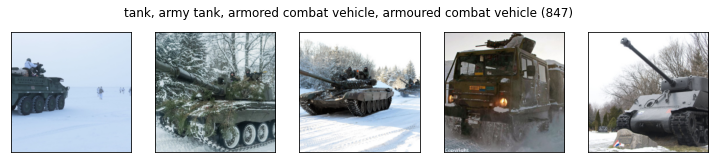

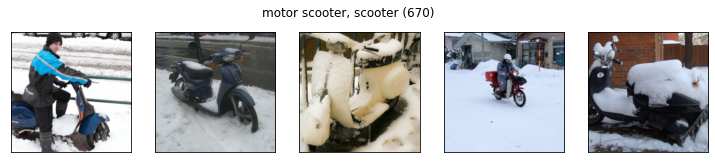

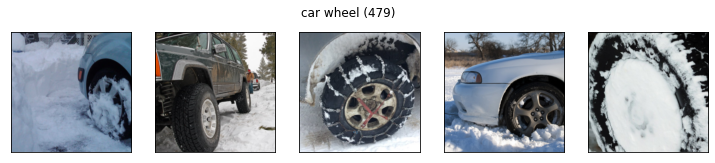

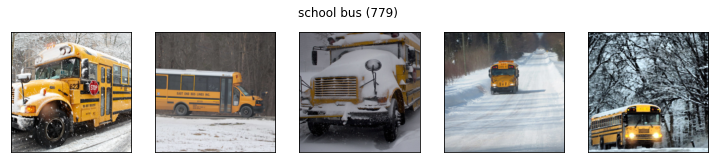

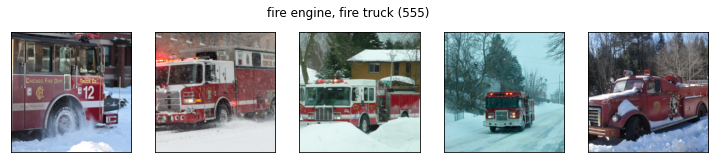

In [7]:
print("Flickr-sourced test set")
for c, x in test_data.items():
    vh.show_image_row([x[:5]], title=f'{CD[c]} ({c})')

## Evaluate model performance on test set pre-rewriting

In [8]:
print("Original accuracy on test vehicles-on-snow data")

RESULTS = {k: {'preds': {}, 'acc': {}} for k in ['pre', 'post']}
for c, x in test_data.items():
    with ch.no_grad():
        pred = model(x.cuda()).argmax(axis=1)
    correct = [p for p in pred if p == c]
    acc = 100 * len(correct) / len(x)
    print(f'Class: {c}/{CD[c]} | Accuracy: {acc:.2f}',) 
    RESULTS['pre']['acc'][c] = acc
    RESULTS['pre']['preds'][c] = pred

Original accuracy on test vehicles-on-snow data
Class: 751/racer, race car, racing car | Accuracy: 40.00
Class: 920/traffic light, traffic signal, stoplight | Accuracy: 66.67
Class: 847/tank, army tank, armored combat vehicle, armoured combat vehicle | Accuracy: 47.06
Class: 670/motor scooter, scooter | Accuracy: 23.81
Class: 479/car wheel | Accuracy: 40.00
Class: 779/school bus | Accuracy: 63.64
Class: 555/fire engine, fire truck | Accuracy: 90.00


## Perform re-write

In [9]:
train_args = {'ntrain': 10, # Number of exemplars
            'arch': ARCH, # Network architecture
            'mode_rewrite': REWRITE_MODE, # Rewriting method ['editing', 'finetune_local', 'finetune_global']
            'layernum': LAYERNUM, # Layer to modify
            'nsteps': 20000 if REWRITE_MODE == 'editing' else 400, # Number of rewriting steps  
            'lr': 1e-4, # Learning rate
            'restrict_rank': True, # Whether or not to perform low-rank update
            'nsteps_proj': 10, # Frequency of weight projection
            'rank': 1, # Rank of subspace to project weights
            'use_mask': True # Whether or not to use mask
             }
train_args = Namespace(**train_args)

In [10]:
context_model = rh.edit_classifier(train_args, 
                                   train_data, 
                                   context_model, 
                                   target_model=target_model, 
                                   val_loader=val_loader,
                                   caching_dir=f"./cache/covariances/{DATASET_NAME}_{ARCH}_layer{LAYERNUM}")

Found precomputed cov matrices, returning...
torch.Size([196, 512])


tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 20000/20000 [03:09<00:00, 105.69it/s]

Loss (orig, final): 0.0019218226661905646 0.0006965934298932552
L2 norm of weight change: 16.381351470947266


## Evaluate model performance on test set post-rewriting

In [11]:
print("Change in accuracy on test vehicles-on-snow data \n")

for c, x in test_data.items():
    with ch.no_grad():
        pred = model(x.cuda()).argmax(axis=1)
    correct = [p for p in pred if p == c]
    acc = 100 * len(correct) / len(x)
    print(f'Class: {c}/{CD[c]} \n Accuracy change: {RESULTS["pre"]["acc"][c]:.2f} -> {acc:.2f} \n',) 
    RESULTS['post']['acc'][c] = acc
    RESULTS['post']['preds'][c] = pred

Change in accuracy on test vehicles-on-snow data 

Class: 751/racer, race car, racing car 
 Accuracy change: 40.00 -> 100.00 

Class: 920/traffic light, traffic signal, stoplight 
 Accuracy change: 66.67 -> 88.89 

Class: 847/tank, army tank, armored combat vehicle, armoured combat vehicle 
 Accuracy change: 47.06 -> 64.71 

Class: 670/motor scooter, scooter 
 Accuracy change: 23.81 -> 47.62 

Class: 479/car wheel 
 Accuracy change: 40.00 -> 45.00 

Class: 779/school bus 
 Accuracy change: 63.64 -> 77.27 

Class: 555/fire engine, fire truck 
 Accuracy change: 90.00 -> 90.00 

